In [1]:
# step 3
from mne.time_frequency import tfr_morlet
from alive_progress import alive_bar
from hm_tools import *
from tqdm import tqdm
import nibabel as nib
import pandas as pd
import numpy as np
# import scipy.io 
import h5py
import mne
import sys
import os
# 计算varibility的代  码要基于mne的epoch文件才可以实现。 

subject_num = 34

mne_erp_loc = 'E:/workspace/Trust_Data_and_Results/Haoming/varibility/data/mne_erp_exp2/'

result_loc = 'E:/workspace/Trust_Data_and_Results/Haoming/varibility/result/varibilit_corr_20_exp2/'

circle = 5 # For exp2, circle=5. For Exp 3, circle=2

file_name = ['alpha'] # only calculate the alpha band 

varibility_method = 'corr' # 'corr' or 'var'

# 时间窗的长度， 单位
time_window = 0.02  
face_per_event = 10

# 需要分析的数据起止时间 第一位是开始的时间，第二位是结束的时间
involve_time = [-0.200, 1.0] 

# the number of face in each event(condition)
face_num_per_condition = 10

In [2]:
# 去除数据残缺的被试
bad_subject = np.array([3, 5, 15]) -1
all_subject = np.arange(0,34,1)

# 删掉特定元素
good_subject = np.setdiff1d(all_subject, bad_subject)

In [3]:
def corr_matrix_insert_nan(input_data, nan_position, values, axis):
    output_data = input_data
    for iter_nan_position in nan_position:# insert nan in every nan position
        # insert nan in two direction
        output_data = np.insert(arr=output_data, obj=iter_nan_position, values=values, axis=axis[0])
        output_data = np.insert(arr=output_data, obj=iter_nan_position, values=values, axis=axis[1])

    return output_data


def varibility_corr(eeg_data, time_series, involve_time, window_length):# eeg_data is 2d (trials * time_series)
    # 通过对比involve_time和epoch的时间序列来找到是第几位数字开始计算相关性

    start_time = np.where(time_series == involve_time[0])[0][0]
    end_time = np.where(time_series == involve_time[1])[0][0]

    # 生成时间序列结果数组
    time_series_var = []

    # 对每个时间窗计算一次变异性
    for iter_window in range(end_time - start_time):# 步长为1
        # 获取每个时间窗的数据 trail 
        iter_data = eeg_data[:,(start_time + iter_window - round(window_length/2)) : (start_time + iter_window + round(window_length/2))]
        # 对该矩阵计算相关系数 
        corr = np.corrcoef(iter_data)
        # 获取对角线以下（k=-1）的下三角
        low_triangle = np.tril(corr, k=-1)
        # 对下三角求和
        all_corr = np.sum(low_triangle)
        # 计算下三角的数据点个数
        corr_num = (eeg_data.shape[0]**2 - eeg_data.shape[0])/2
        # 计算平均相关性
        average_corr = all_corr/corr_num
        # 通过1-计算差异性
        average_var = 1 - average_corr
        # 得到每个时间序列的结果
        time_series_var.append(average_var)

    return time_series_var #输出结果矩阵 time



In [33]:
# preload to check information
# read the epoch data
eeg_epochs = mne.read_epochs(mne_erp_loc + '/subject_1' +'/' + file_name[0] + '_epo.fif', preload = True)

time_series = np.array(eeg_epochs.times)
# 检查event的数量
event_name = eeg_epochs.event_id.keys()
event_name = list(event_name)

event_num = len(event_name)

# check the number of eeg electrode
eeg_data = eeg_epochs.get_data()
electrode_num = eeg_data.shape[1]

# calculate how many power band 
power_band_num = len(file_name)

# calculate how many good subject
good_subject_num = len(good_subject)

# check how many time point in the result 
result_time_length = int(eeg_epochs.info['sfreq'] * (involve_time[1] - involve_time[0]))

# calculate the time point of each window
if varibility_method == 'corr':
    window_length = eeg_epochs.info['sfreq'] * time_window 
    print('point of the window is:', window_length)


Reading E:/workspace/Trust_Data_and_Results/Haoming/varibility/data/mne_erp_exp3//subject_1/alpha_epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -700.00 ...    1499.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
point of the window is: 20.0


In [ ]:
# 平均变异性
all_rsa_result=[]
all_result = np.full((subject_num, power_band_num, event_num, circle, electrode_num, result_time_length),np.nan)
for iter_subject in good_subject:

    # 生成每个被试的erp数据存放地址
    subject_erp_loc = mne_erp_loc + '/subject_' + str(iter_subject + 1)

    iter_subject_result = np.full((power_band_num, event_num, circle, electrode_num, result_time_length),np.nan)
    # 包括3个波段，各循环一次
    for iter_file in range(power_band_num):
        
        # read the epoch data
        eeg_epochs = mne.read_epochs(subject_erp_loc +'/' + file_name[iter_file] + '_epo.fif', preload = True)

        iter_power_result = np.full((event_num, circle, electrode_num, result_time_length),np.nan)    
        
        # 对每一个event分别进行一次计算（可以大于2个） 两种计算方法
        for iter_event in range(event_num):

            # 提取每一个event的脑电数据
            iter_event_eeg_data =  eeg_epochs[event_name[iter_event]].get_data()

            # Generate nan matrix for each event (circle * channel * time * trials * trials)
            iter_event_result = np.full((circle, electrode_num, result_time_length), np.nan)
            for iter_influence_step in range(circle):
                # 提取每一个 influence step 的脑电数据    
                iter_influence_step_eeg_data = iter_event_eeg_data[10*iter_influence_step:10*iter_influence_step+10]
                
                # 检查其中有没有nan，如果有就记录下nan的位置并且把nan位置的数据删除
                nan_position, not_nan_position = find_1d_array_nan(iter_influence_step_eeg_data[:,0,0])
                if len(nan_position) > 0:
                    iter_influence_step_eeg_data = iter_influence_step_eeg_data[not_nan_position]
                
                # Generate nan matrix for each influence step (channel * time * trials * trials)
                iter_influence_step_result=np.full((electrode_num, result_time_length), np.nan)
                for iter_electrode in range(iter_influence_step_eeg_data.shape[1]):
                    
                    if varibility_method == 'corr':
                        time_series_corr_matrix = varibility_corr(iter_influence_step_eeg_data[:,iter_electrode,:], time_series, involve_time, window_length)
                        time_series_corr_matrix = time_series_corr_matrix / np.mean(time_series_corr_matrix[0:int(np.abs(involve_time[0])*eeg_epochs.info['sfreq'])])
                        # time_series_corr_matrix = rsa_2_variability(time_series_corr_matrix)
                    else:
                        print('ERROR: wrong varibility_method name!' )
                    # save the result per event
                    iter_influence_step_result[iter_electrode] = time_series_corr_matrix # channel * time * trials * trials
                
                # save the iter influence_step data to previously generated nan iter_event matrix
                iter_event_result[iter_influence_step] = iter_influence_step_result

            # save the iter event data to previously generated nan iter_power matrix
            iter_power_result[iter_event] = iter_event_result

        # load the iter power data to previously generated nan iter_subject matrix
        iter_subject_result[iter_file] = iter_power_result

    # load the iter subject data to previously generated nan all result matrix
    all_result[iter_subject] = iter_subject_result

    print('')
    print("**************************************************************************") 
    print("******************** subject number:", iter_subject + 1, "/", subject_num,"finished *********************")
    print("**************************************************************************")        
    print('')

all_rsa_result['data'] = all_result
np.save(result_loc +'/' + 'face_alpha_var_nor_result.npy', all_rsa_result)


# Data analysis part

In [3]:
# import the variation of Exp2 and Exp3 

result3_loc = 'E:/workspace/Trust_Data_and_Results/Haoming/varibility/result/varibilit_corr_20_exp3/'
all_var_result2 = np.load(result_loc +'/' + 'face_alpha_var_nor_result.npy', allow_pickle=True).item()
all_var_result3 = np.load(result3_loc +'/' + 'face_alpha_var_nor_result.npy', allow_pickle=True).item()
print(all_var_result2['data'].shape)

(34, 1, 4, 5, 63, 1200)


In [4]:
# concatenate the data of Exp2 and Exp 3
all_var_result2_data = np.squeeze( all_var_result2['data'])
all_var_result3_data = np.squeeze(all_var_result3['data'])
print(all_var_result3_data.shape)
all_var_result23_data = np.concatenate((all_var_result2_data,all_var_result3_data),axis=2)
print(all_var_result23_data.shape)

(34, 4, 2, 63, 1200)
(34, 4, 7, 63, 1200)


In [5]:
# Devide 63 electrode to 6 regions
region_ch_list={}
region_ch_list[0] = ['FT9','Fp1', 'Fpz', 'AF7','F7','FT7','AF3','F5','F3','F1','Fz','FC1','FC3','FC5']
region_ch_list[1] = ['FT10', 'Fpz', 'Fz', 'FC2', 'FC4', 'FC6', 'FT8', 'F2', 'F4', 'F6', 'F8', 'AF4', 'AF8', 'Fp2']
region_ch_list[2] = ['TP9','FT9','FC1','FC3','FC5', 'FT7', 'Cz', 'CPz', 'CP1', 'CP3', 'CP5', 'TP7', 'T7', 'C5', 'C3', 'C1']
region_ch_list[3] = ['TP10','FT10', 'FC2', 'FC4', 'FC6', 'FT8', 'Cz', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'T8', 'C6', 'C4', 'C2']
region_ch_list[4] = ['TP9','Oz', 'POz', 'Pz', 'CPz', 'CP1', 'CP3', 'CP5', 'TP7', 'P1', 'P3', 'P5', 'P7', 'PO3', 'PO7', 'O1']
region_ch_list[5] = ['TP10','Oz', 'POz', 'Pz', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'P2', 'P4', 'P6', 'P8', 'PO4', 'PO8', 'O2']

ch_names = all_var_result2['ch_names']
region_ch_location={}

for iter_region in range(6):
    region_ch_location[iter_region]=[]
    for iter_channel in range(len(region_ch_list[iter_region])):
        iter_channel_position = np.where(np.array(ch_names) == region_ch_list[iter_region][iter_channel])[0][0]

        region_ch_location[iter_region].append(iter_channel_position)

# Map the data of 63 eectrodes to 6 regions
region_all_var_result23_data = np.full((34,4,7,6,1200), np.nan)
for iter_region in range(6):
    region_all_var_result23_data[:,:,:,iter_region,:] = np.mean(all_var_result23_data[:,:,:,region_ch_location[iter_region],:],axis=3)

print(region_all_var_result23_data.shape)

(34, 4, 7, 6, 1200)


In [ ]:
# Calculate the 1_samp permutation test 
n_permutations=10000
permutation_cluster_result = {}
# calculate std
permu_result_loc = 'E:/workspace/Trust_Data_and_Results/Haoming/varibility/result/varibilit_corr_20_exp2/perm_result/'

cond0_region_all_var_result23_data = region_all_var_result23_data[:,0,:,:,:]
print(region_all_var_result23_data.shape)
# tfr_ROI_epoch_data_std={}
# tfr_ROI_epoch_data_std['all_event_std'] = np.std(np.squeeze(all_data_nor['data'][:, :, 0, :, :]), axis=0)
# tfr_ROI_epoch_data_std['event1_std'] = np.std(np.squeeze(all_data_nor['data'][:, :, 1, :, :]), axis=0)
# tfr_ROI_epoch_data_std['event2_std'] = np.std(np.squeeze(all_data_nor['data'][:, :, 2, :, :]), axis=0)

# permutation_cluster_result['std_error'] = tfr_ROI_epoch_data_std

      
for iter_channel in range(6):
    #ROI_num = 10
    # compute the cluster test for event 1
    iter_channel_result = {}
    for iter_event in range(7):
        T_obs, clusters, cluster_p_values, H0  = mne.stats.permutation_cluster_1samp_test(cond0_region_all_var_result23_data[good_subject, iter_event, iter_channel, :]-1, out_type='mask',n_permutations=n_permutations, tail=0, verbose=None)
        iter_event_result = {'T_obs':T_obs, 'clusters':clusters, 'cluster_p_values':cluster_p_values, 'H0':H0}

        iter_channel_result[iter_event] = iter_event_result

    
        print('')
        print("**************************************************************************")
        print("********************* total number:", iter_channel*7+iter_event + 1, "/", 42,"finished ***********************")
        print("**************************************************************************")
        print('')
    permutation_cluster_result[iter_channel] = iter_channel_result

if not os.path.exists(permu_result_loc):
    os.makedirs(permu_result_loc)
np.save(permu_result_loc + 'exp23_permu_result' + '.npy', permutation_cluster_result)




In [5]:
permu_result_loc = 'E:/workspace/Trust_Data_and_Results/Haoming/varibility/result/varibilit_corr_20_exp2/perm_result/'

permutation_cluster_result = np.load(permu_result_loc + 'exp23_permu_result' + '.npy', allow_pickle=True).item()


In [20]:
# function of plot the permutation result 
import matplotlib.pyplot as plt
import numpy as np
import os
def plot_erp(permutation_cluster_result, epoch_mean, epoch_data_std, times, event_name, line_color=['orangered','limegreen'], 
            figsize=(14,6), title_size=25, legend_size=15, labelsize=15, ticksize=20, subplots_adjust=[0.15, 0.15, 0.85, 0.85]):
    # keys of the dict permutation_cluster_result
    #'event1_result':event1_result, 'event2_result':event2_result, 'compare_result':compare_result}
    #'T_obs':T_obs, 'clusters':clusters, 'cluster_p_values':cluster_p_values, 'H0':H0

    # keys of the dict epoch_data_mean
    # 'event_0' (34, 1300)
    # plot for each ROI

    event_0_line_color = line_color[0]
    event_1_line_color = line_color[1]
    event_2_line_color = line_color[2]


    plt.close('all')
    plt.rcParams['figure.figsize'] = figsize # 设置figure_size尺寸
    event_num_plot = [0,2,5]
    # (34, 6, 3, 63, 1300)
    # epoch_mean={}
    # epoch_mean[0] = np.squeeze(np.average(epoch_data['event_0'], axis=0))
    # epoch_mean[1] = np.squeeze(np.average(epoch_data['event_1'], axis=0))
    for iter_event_num in range(len(event_num_plot)):
        
        iter_color = line_color[iter_event_num]
        iter_event = event_num_plot[iter_event_num]
        plt.plot(times, epoch_mean[iter_event], color=iter_color, linestyle='--', alpha=0.4)


        plt.fill_between(times, epoch_mean[iter_event] - epoch_data_std[iter_event], epoch_mean[iter_event] + epoch_data_std[iter_event], color=iter_color, alpha=0.1)

        # event 0 的显著性
        for i_c, c in enumerate(permutation_cluster_result[iter_event]['clusters']):
            c = c[0]
            if permutation_cluster_result[iter_event]['cluster_p_values'][i_c] <= 0.05:
                plt.plot(times[c.start : c.stop - 1], epoch_mean[iter_event][c.start : c.stop-1], color=iter_color, alpha=0.9)



    #hf = plt.plot(times, T_obs, 'g')
    #plt.legend((h, ), ('cluster p-value < 0.05', ))
    plt.subplots_adjust(left=subplots_adjust[0], bottom=subplots_adjust[1], right=subplots_adjust[2], top=subplots_adjust[3],                         hspace=0.1,wspace=0.1)

    plt.xlim([times[0]-0.02, times[-1]+0.02])

    plt.yticks(size=ticksize, family='Arial')
    plt.xticks(size=ticksize, family='Arial')


    return plt


(7, 1200)
(7, 1200)
(7, 1200)
(7, 1200)
(7, 1200)
(7, 1200)


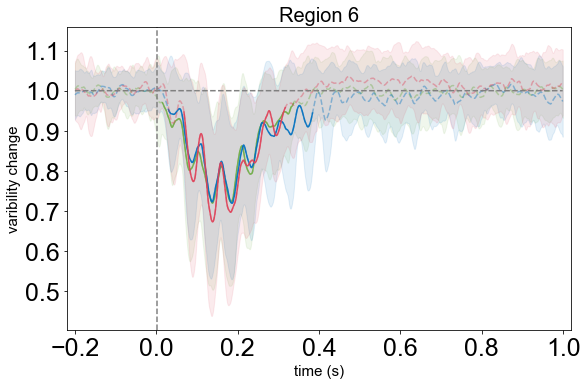

In [24]:
# plot varibility erps and permuation result of the variation of Exp2 and Exp3
import matplotlib.pyplot as plt
from matplotlib import font_manager
plot_result_loc = result_loc + '/Exp2_condition0_plot_result/'
# permutation_cluster_result = np.load(permu_result_loc + 'all_event_0_1_alpha' + '.npy', allow_pickle=True).item()
figsize=(12,6)
title_size = 20
labelsize = 15
ticksize=25
fontProperties = font_manager.FontProperties(fname='C:/Windows/Fonts/arial.ttf')
times = np.arange(-0.2, 1, 0.001)
event_name = ['Exp 2 step 1', 'Exp 2 step 3', 'Exp 3 step 6']

chan_name = ['Region 1', 'Region 2', 'Region 3', 'Region 4', 'Region 5', 'Region 6']
# for iter_file in range(len(file_name)):

cond0_region_all_var_result23_data = region_all_var_result23_data[:,0,:,:,:]
if not os.path.exists(plot_result_loc):
    os.makedirs(plot_result_loc)


for iter_chan in range(6):

    iter_region_all_var_result23_data = cond0_region_all_var_result23_data[good_subject,:,iter_chan,:]


    iter_region_all_var_result23_data_std = np.std(iter_region_all_var_result23_data, axis=0)

    iter_region_all_var_result23_data_mean = np.average(iter_region_all_var_result23_data, axis=0)
    print(iter_region_all_var_result23_data_mean.shape)



    plt = plot_erp(permutation_cluster_result[iter_chan], iter_region_all_var_result23_data_mean, 
                    iter_region_all_var_result23_data_std, times, event_name, ticksize = ticksize,
                    line_color=['#70AD47','#0070C0', '#DF4058'], figsize = figsize)


    plt.title(chan_name[iter_chan], family='Arial', fontdict= {'fontsize':title_size})

    plt.xlabel("time (s)", fontsize=labelsize, family='Arial')
    plt.ylabel("varibility change", fontsize=labelsize, family='Arial')


    plt.axvline(times[201], c="gray", ls = "dashed")
    plt.plot(times, np.ones(len(times)), color="gray", linestyle="dashed")

    plt.savefig(plot_result_loc + '/' + chan_name[iter_chan] + ".png")



In [13]:
# calculate the temporal mean eeg variability 0-300ms
mean_region_all_var_result23_data = np.mean(region_all_var_result23_data[:,:,:,:,200:500],axis=-1)
mean_region_all_var_result23_data.shape

(34, 4, 7, 6)

In [14]:
# step 1 and step 2 (pre-influence)
mean_region_all_var_result23_data_123 = np.mean(mean_region_all_var_result23_data[:,:,0:2],axis=2)
mean_region_all_var_result23_data_123.shape
all_corr_result = mean_region_all_var_result23_data_123

In [15]:
# Load the behavior data of Exp2 & 3
behaviorVar_loc = 'E:/workspace/Trust_Data_and_Results/Haoming/varibility/behavior_result/behavior_varibility.npy'
behavior_varibility = np.load(behaviorVar_loc)
behavior_varibility.shape

(34, 4)

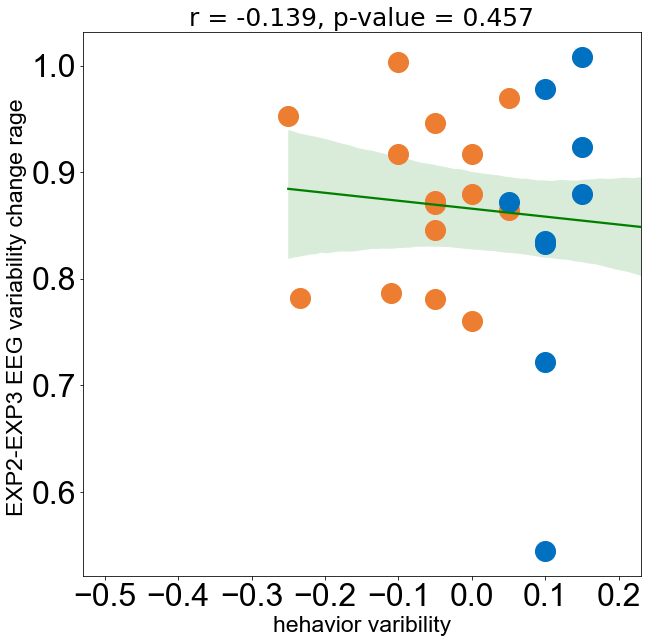

In [20]:
# Plot：Use the 1-3 mean EEG variability to predict the Exp2-3 behavior change. # mean_all_rsa_result23_0_300

import seaborn as sns
import scipy
import scipy.stats
import matplotlib.pyplot as plt

figsize=(10,10)
title_size=25
legend_size=15 
labelsize=23
ticksize=32
plot_loc = 'E:/workspace/Trust_Data_and_Results/Haoming/varibility/result/varibilit_corr_20_exp2/each_influence_varibility/var1_2_mean_predict_behavior_6region_0_300_plot/'
event_name = ['trust0', 'trust1', 'trust2', 'trust3']


all_corr_r, all_corr_p = [], []
for iter_event in range(len(event_name)):

    # Generate the correlation image storage address of each condition (Experiment 2 and experiment 3)  
    iter_event_loc = plot_loc + event_name[iter_event] + '/'
    if not os.path.exists(iter_event_loc):
        os.makedirs(iter_event_loc)
        
    for iter_channel in range(all_corr_result.shape[-1]):
    
        # Extract behavioral data to X and eeg variability to Y
        x = behavior_varibility[good_subject, iter_event]
        y = all_corr_result[good_subject, iter_event, iter_channel]

        # Calculate correlations and statistical significance, and store results
        scipy_corr = scipy.stats.pearsonr(x, y)

        # Plot the results for each regions
        plt.close('all')
        plt.rcParams['figure.figsize'] = figsize # set figure_size

        # Significant plots are shown in red and non-significant plots in green
        if scipy_corr[1] <= 0.05:
            sns.regplot(x=x, y=y, color="r") 
        else:
            sns.regplot(x=x, y=y, color="g") 

        small2large_position = np.argsort(x)

        plt.scatter(x[small2large_position[0:15]],y[small2large_position[0:15]],marker = 'o', color='#ED7D31', s=400)
        plt.scatter(x[small2large_position[15:]],y[small2large_position[15:]],marker = 'o', color='#0070C0', s=400)
        plt.title('r = '+ str(round(scipy_corr[0], 3)) + ', p-value = '+ str(round(scipy_corr[1], 3)), fontsize=title_size)
        plt.xlabel("hehavior varibility", fontsize=labelsize, family='Arial')
        plt.ylabel("EXP2-EXP3 EEG variability change rage ", fontsize=labelsize, family='Arial')

        plt.yticks(size=ticksize, family='Arial')
        plt.xticks(size=ticksize, family='Arial')
        plt.xlim([-0.53, 0.23])  #event0:  -0.53, 0.23   #event1:  -0.33, 0.38

        iter_plot_loc = iter_event_loc + '/' + str(iter_channel+1) + '_corr.png'

        plt.savefig(iter_plot_loc)

